In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

### load from 1050ns OPES_METAD simulation ->

In [2]:
time, ld1, cleft_dist, dihedral = \
np.loadtxt("/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/COLVAR_EDITED", usecols=(0,1,2,3), unpack=True)

time *= 1e-3 # in ns

### load trajectory data from 1050ns OPES_METAD simulation ->

In [3]:
# read trajectory data
path = "/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data"
atoms_selection = "name CA"
print("selected atoms:", atoms_selection)

# load data
prmtopFileName =  path + "/s1_init_protein_only.gro"
trajFiles = [path+"/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_atoms = coord.select_atoms(atoms_selection)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_atoms.n_atoms,3),dtype=float)
count = 0

# no need to multiply by 10
for ts in coord.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

selected atoms: name CA
['/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr']
1
Number of atoms in trajectory: 5835
Number of frames in trajectory: 21001
Number of atoms being analyzed: 375
Number of frames being analyzed: 21001


## get the Final FE from this 1050ns data ->
1. use the STATES file to get 2D FE on LD1 vs. Dihedral
2. Use the final bias weights to get 2D FE on cleft distance vs dihedral

### 1.

(100,)
(100, 100)


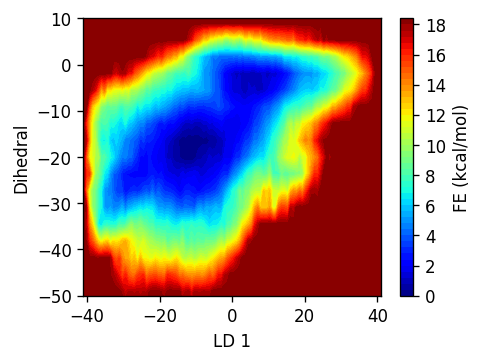

In [4]:
ld1_grids = np.linspace(-41.0, 41.0, 100, endpoint=True)
dihedral_grids = np.linspace(-np.pi, np.pi, 100, endpoint=True)
print(ld1_grids.shape)

# load the final FE from final STATE file  (time=1050ns)
fe_state_final = \
np.loadtxt("/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/2d_fe_actin_ld1+dihedral.dat", usecols=2).reshape([100,100])/4.184
print(fe_state_final.shape)

plt.figure(figsize=(4,3), dpi=120)
plt.ylim(-50.0,10)
plt.xlabel("LD 1")
plt.ylabel("Dihedral")
plt.contourf(ld1_grids, dihedral_grids*180/3.14, fe_state_final, cmap="jet", levels=50)
cbar=plt.colorbar()
cbar.set_label("FE (kcal/mol)")
#plt.scatter(ld1, dihedral*180/3.14, marker='.', s=0.02, color="k", alpha=0.06)

### 2.

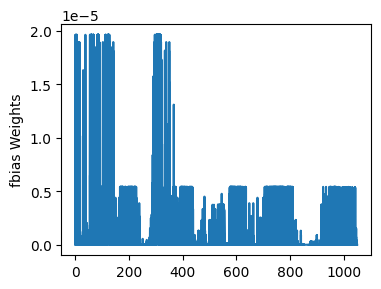

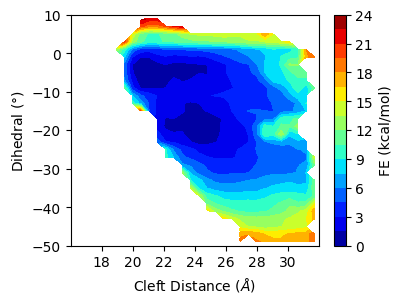

In [5]:
kt = 0.616033   # @T=310K in kcal/molK unit

# get the final bias weights 
x_indx = np.digitize(ld1, ld1_grids, right=True)
y_indx = np.digitize(dihedral, dihedral_grids, right=True)

weights = np.empty(time.shape[0])
for i in range(time.shape[0]):
    weights[i] = np.exp(-fe_state_final.T[x_indx[i], y_indx[i]]/kt)
    

# plot the weights 
plt.figure(figsize=(4,3), dpi=100)
plt.ylabel("fbias Weights")
#plt.plot(time, weights)
plt.plot(time, weights/np.sum(weights))
#plt.plot(time, np.log(weights/np.sum(weights)))

# get the FE
hist, xedges, yedges = np.histogram2d(cleft_dist*10.0, dihedral*180/3.14, bins=[30,30], range=[[16,32],[-50,10]], density=True, weights=weights)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe = -kt*np.log(hist)
fe -= fe.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4,3), dpi=100)
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-50,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")
#plt.contour(xx, yy, fe.T, cmap='binary', levels=10, linestyles="--")
plt.contourf(xx, yy, fe.T, cmap="jet", levels=20)
cbar = plt.colorbar()
cbar.set_label("FE (kcal/mol)")

### Definition of different subdomains of actin monomer from Paper -->

In [6]:
# 1-based indexing here
b1_range = [[5,33], [80,147], [334,349]]
b2_range = [[34,39], [52,69]]
b3_range = [[148,179], [273,333]]
b4_range = [[180, 219],[252,262]]

subdomains = [b1_range, b2_range, b3_range, b4_range]

# will keep this as 0-based indexing
residue_indices = []

# loop over domains
for i in range(len(subdomains)):
    
    x = subdomains[i]
    indx_list = []
    
    # loop over ranges in domain 
    for j in range(len(x)):
        a = np.arange(x[j][0], x[j][1]+1) - 1  # subtracting 1 to make it 0-based. 
        indx_list.append(a)    
    indx_list = np.concatenate(indx_list, axis=0)
    
    residue_indices.append(indx_list)
#print(residue_indices)    

### load 5 Clusters gmm object for actin obtained later with huge amount of data ->

In [7]:
with open("/scratch/projects/hockygroup/ss12902/posLDA_actin\
/cluster_opes_data_from_triasha/run_with_v1.6.1/wrapped_trajs_for_actin/wsgmm_5state_all_data.pickle", "rb") as f_o:
    wsgmm5 = pickle.load(f_o)

print(wsgmm5.weights)
print(wsgmm5.cluster_ids.shape)

[0.3506144  0.18298696 0.17507292 0.1514043  0.13992141]
(153564,)


### use wsgmm5 to predict the cluster identity on 1050ns OPES_METAD data ->

In [8]:
wsgmm5.device = torch.device("cpu")
cluster_ids_predicted, _, _ = wsgmm5.predict(trajData, frame_weights = weights[::50])
print(cluster_ids_predicted.shape)

(21001,)


### get the positions of cluster centers on cleft dist and dihedral space 

In [9]:
cluster_indx = []
for i in range(wsgmm5.n_clusters):
    indx = [x[0] for x in np.argwhere(cluster_ids_predicted == i)]
    cluster_indx.append(indx)
    print(len(indx))

dihedral_centers = [np.mean(dihedral[::50][cluster_indx[i]])*180/3.14 for i in range(wsgmm5.n_clusters)]
cleft_dist_centers = [np.mean(cleft_dist[::50][cluster_indx[i]])*10.0 for i in range(wsgmm5.n_clusters)]
ld1_centers = [np.mean(ld1[::50][cluster_indx[i]]) for i in range(wsgmm5.n_clusters)]

2659
1977
2605
1138
12622


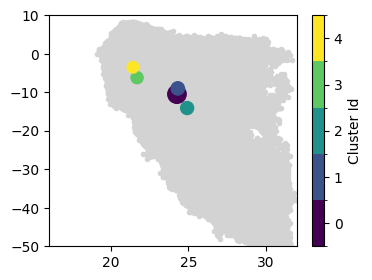

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

plt.figure(figsize=(4,3))
plt.xlim(16,32)
plt.ylim(-50,10)
plt.scatter(cleft_dist*10.0, dihedral*180.0/3.14, marker=".", color="lightgrey")
plt.scatter(cleft_dist_centers, dihedral_centers, marker="o", c=np.arange(wsgmm5.n_clusters), s=wsgmm5.weights*500, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.arange(0.5, wsgmm5.n_clusters, 1))
cbar.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar.set_label("Cluster Id")

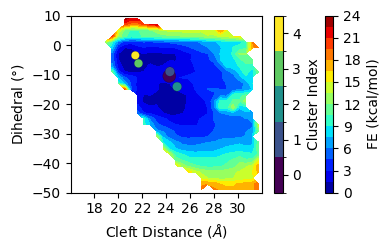

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

# get the FE
hist, xedges, yedges = np.histogram2d(cleft_dist*10.0, dihedral*180/3.14, bins=[30,30], range=[[16,32],[-50,10]], density=True, weights=weights)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe = -kt*np.log(hist)
fe -= fe.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4,2.6), dpi=100)
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-50,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")

im1 = plt.contourf(xx, yy, fe.T, cmap="jet", levels=20)
cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*250.0, edgecolor="k", linewidth=0.1)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

plt.tight_layout()
plt.savefig("2d_fes_opes_1050ns_data.pdf", format="pdf")

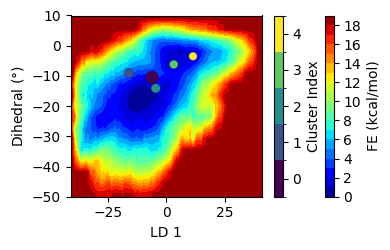

In [12]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

plt.figure(figsize=(4,2.6), dpi=100)
plt.ylim(-50.0,10)
plt.xlabel("LD 1")
plt.ylabel("Dihedral ($\\degree$)")
im1 = plt.contourf(ld1_grids, dihedral_grids*180/3.14, fe_state_final, cmap="jet", levels=20)
cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(ld1_centers, dihedral_centers, marker="o", c=np.arange(wsgmm5.n_clusters), s=wsgmm5.weights*250, cmap=cmap, norm=norm, edgecolor="k", linewidth=0.1)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

plt.tight_layout()

plt.savefig("2d_fes_opes_1050ns_data_ld1_vs_dihedral.pdf", format="pdf")

### use the gmm object to predict FE for sampled points ->

In [13]:
## ------------------------------------------------
## load the colvar data produced later for training
## ------------------------------------------------

data_path="/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/wrapped_trajs_for_actin"
n_frames = 191
n_restarts = 4
colvar_data = []

for i in range(n_frames):
    for j in range(n_restarts):
        colvar_file = data_path+"/frame{}/{}/frame{}_{}_colvar.txt".format(i,j+1,i,j+1)
        colvar = np.loadtxt(colvar_file)
        colvar_data.append(colvar)

colvar_data = np.concatenate(colvar_data, axis=0)
print(colvar_data.shape)

kt = 0.616033   # @T=310K in kcal/molK unit
ld1_rst = colvar_data[:,0]
cleft_dist_rst = colvar_data[:,1]*10.0
dihedral_rst = colvar_data[:,2]*180.0/3.14

(153564, 4)


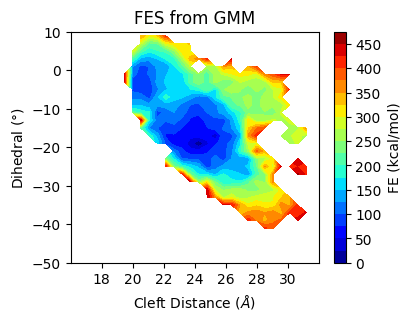

In [14]:
log_likes_scaled= wsgmm5.train_frame_log_likelihood - np.amax(wsgmm5.train_frame_log_likelihood)
#H, x, y = np.histogram2d(cleft_dist_rst, dihedral_rst, bins=100, range=[[16,32],[-50,10]], weights=np.exp(wsgmm5.train_frame_log_likelihood))
H, x, y = np.histogram2d(cleft_dist_rst, dihedral_rst, bins=30, range=[[16,32],[-50,10]], weights=np.exp(log_likes_scaled))

binweight = np.histogram2d(cleft_dist_rst, dihedral_rst, bins=30, range=[[16,32],[-50,10]], weights=np.ones(cleft_dist_rst.shape[0]))[0]
fe_gmm = -kt*(np.log(H) - np.log(binweight))
fe_gmm -= fe_gmm[~np.isnan(fe_gmm)].min()

xbins = (x[1:]+x[:-1])/2.0
ybins = (y[1:]+y[:-1])/2.0
xx, yy = np.meshgrid(xbins, ybins)

plt.figure(figsize=(4,3), dpi=100)
plt.title("FES from GMM")
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-50,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")
plt.contourf(xx, yy, fe_gmm.T, cmap="jet", levels=20)

cbar = plt.colorbar()
cbar.set_label("FE (kcal/mol)")

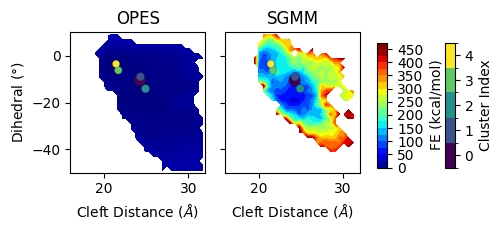

In [15]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2.5), dpi=100)


#0
axs[0].set_title("OPES")
axs[0].set_xlabel("Cleft Distance ($\\AA$)")
axs[0].set_ylabel("Dihedral ($\degree$)")
axs[0].set_xlim(16,32)
axs[0].set_ylim(-50,10)

im1 = axs[0].contourf(xx, yy, fe.T, cmap="jet", levels=20, vmin=0.0, vmax=450.0)
p1 = axs[0].scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*200.0, edgecolor="k", linewidth=0.1)


#1
axs[1].set_title("SGMM")
axs[1].set_xlabel("Cleft Distance ($\\AA$)")

im2 = axs[1].contourf(xx, yy, fe_gmm.T, cmap="jet", levels=20, vmin=0.0, vmax=450.0)
p2 = axs[1].scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*200.0, edgecolor="k", linewidth=0.1)


cbar_ax = fig.add_axes([0.765, 0.29, 0.02, 0.5])  # [x, y, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label("FE (kcal/mol)")

cbar_ax_1 = fig.add_axes([0.90, 0.29, 0.02, 0.5])  # [x, y, width, height]
cbar_1 = fig.colorbar(p2, cax=cbar_ax_1)
cbar_1.set_ticks(np.arange(0.5,wsgmm5.n_clusters,1))
cbar_1.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_1.set_label("Cluster Index")


fig.tight_layout(rect=[0,0.02,0.76,0.98])  # rect=[left, bottom, right, top]
plt.savefig("actin_main_figure.pdf", format="pdf")

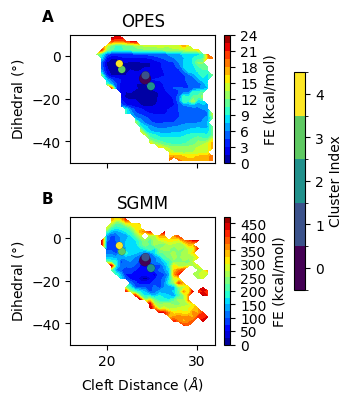

In [16]:
## make the same figure with separate colorbar !
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(3.65,4.35), dpi=100)

#0
axs[0].text(-0.2, 1.2, "A", transform=axs[0].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
axs[0].set_title("OPES")
axs[0].set_ylabel("Dihedral ($\degree$)")
axs[0].set_xlim(16,32)
axs[0].set_ylim(-50,10)

im1 = axs[0].contourf(xx, yy, fe.T, cmap="jet", levels=20)
p1 = axs[0].scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*200.0, edgecolor="k", linewidth=0.1)
cbar1 = plt.colorbar(im1, ax=axs[0])
cbar1.set_label("FE (kcal/mol)")

#1
axs[1].text(-0.2, 1.2, "B", transform=axs[1].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
axs[1].set_title("SGMM")
axs[1].set_ylabel("Dihedral ($\degree$)")
axs[1].set_xlabel("Cleft Distance ($\\AA$)")

im2 = axs[1].contourf(xx, yy, fe_gmm.T, cmap="jet", levels=20)
p2 = axs[1].scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*200.0, edgecolor="k", linewidth=0.1)
cbar2 = plt.colorbar(im2, ax=axs[1])
cbar2.set_label("FE (kcal/mol)")


new_ax = fig.add_axes([0.82, 0.29, 0.03, 0.5])  # [x, y, width, height]
cbar_ = fig.colorbar(p2, cax=new_ax)
cbar_.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_.set_label("Cluster Index")

fig.tight_layout(rect=[0,0.02,0.80,0.98])  # rect=[left, bottom, right, top]
plt.savefig("compare_FEs_opes_gmm_vertical.pdf", format="pdf")

## Try using synthetic trajectories to estimate FES ->

### functions for generating synthetic trajectory -->

In [17]:
from scipy.stats import multivariate_normal

def gen_trj_cluster(cluster_mean, cluster_covariance, scale=1, N_samples=10000):
    rv = multivariate_normal(mean=cluster_mean.flatten(), cov=cluster_covariance*scale, allow_singular=True)
    trj = rv.rvs(size=N_samples).reshape(N_samples, -1, 3)
    return cluster_mean, trj

def pseudo_inv(mat,remove):
    # it calculates the pseudo inverse of a singular matrix
    e, v = np.linalg.eigh(mat)
    e[remove:] = 1/e[remove:]
    e[:remove] = 0.00
    return np.dot(v,np.dot(np.diag(e),v.T))

In [18]:
# population of clusters ->
print("population in % :", [i for i in wsgmm5.weights*100])

population in % : [35.06144039645708, 18.298696408445846, 17.507292031810117, 15.140430288105092, 13.992140875181866]


### generate the trajectory ->

In [19]:
means = []
trjs = []
covars = []
for i in range(wsgmm5.n_clusters):
    covar = np.kron(pseudo_inv(wsgmm5.precisions[i], 1), np.identity(3))
    
    meani, trji = gen_trj_cluster(wsgmm5.centers[i], covar, \
                                  scale=1, N_samples=round((wsgmm5.weights[i]*100)*10500))
    covars.append(covar)
    means.append(meani)
    trjs.append(trji)

In [20]:
trjs_combined = np.concatenate(trjs, axis=0)
print(trjs_combined.shape)

(1050000, 375, 3)


In [21]:
new_data_synthetic = np.empty([trjs_combined.shape[0], 4, 3])

# loop over domains
for i in range(4):
    
    # ith domain
    bi = trjs_combined[:,residue_indices[i], :]
    bi_com = np.mean(bi, axis=1)
    
    new_data_synthetic[:,i,:] = bi_com

In [22]:
from MDAnalysis.lib.distances import calc_dihedrals

dihedral_synthetic = calc_dihedrals(new_data_synthetic[:,1,:], new_data_synthetic[:,0,:], new_data_synthetic[:,2,:], new_data_synthetic[:,3,:])*180/3.14
cleft_dist_synthetic = np.sqrt(np.sum(np.square(new_data_synthetic[:,1,:] - new_data_synthetic[:,3,:]), axis=1))

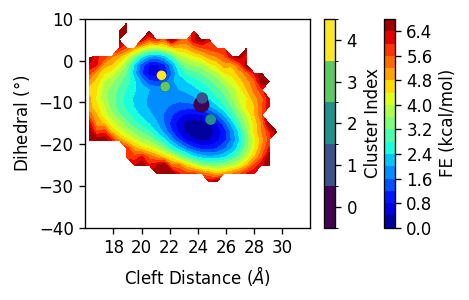

In [23]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

kt=0.616033 # in kcal/mol unit
hist, xedges, yedges = np.histogram2d(cleft_dist_synthetic, dihedral_synthetic, bins=[30,30], range=[[16,32],[-50,10]], density=True)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe = -kt*np.log(hist)
fe -= fe.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4,2.6), dpi=120)
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-40,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")
im1 = plt.contourf(xx, yy, fe.T, cmap="jet", levels=20)
cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(cleft_dist_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*250.0, edgecolor="k", linewidth=0.1)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

plt.tight_layout()

### calculate the lda CV also from synthetic trajectory 

### functions for calculating the lda projections ->

In [24]:
def kabsch_rotate(mobile, ref):
    correlation = np.dot(mobile.T,ref)
    v, s, w_tr = np.linalg.svd(correlation)
    # enforce determinant of rotation matrix is 1 (not negative 1)
    if np.linalg.det(v) * np.linalg.det(w_tr) < 0.0:
        v[:,-1] *= -1
    rotation = np.dot(v, w_tr)
    # rotate
    return np.dot(mobile,rotation)

def project_trajectory_lda_weighted(trajectory, ref, precision, lda_vector):
    # meta data
    n_frames = trajectory.shape[0]
    n_atoms = trajectory.shape[1]
    # check everything else has matching size
    assert ref.shape[0] == n_atoms, "Atom numbers different in trajectory and reference"
    assert precision.shape[0] == n_atoms, "Atom numbers different in trajectory and precision"
    assert lda_vector.shape[0] == n_atoms*3, "LDA vector dimension do not match trajectory"
    # declare arrays
    projections = np.empty(n_frames,dtype=np.float64)
    # loop over trajectory
    weighted_ref = np.dot(precision, ref)
    for frame in range(n_frames):
        disp = (kabsch_rotate(trajectory[frame],weighted_ref) - ref).flatten()
        projections[frame] = np.dot(disp,lda_vector)
    return projections

In [25]:
## load the ref, prec and lda vector  (NOTE: remember they are in nm !!!!!)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
path_to_files = "/scratch/projects/hockygroup/ss12902/posLDA_actin/"
global_avg = np.loadtxt(path_to_files+"global_avg.txt")
global_prec = np.loadtxt(path_to_files+"global_prec.txt")
ld1_vector = np.loadtxt(path_to_files+"ld1_scalings.txt")

print(global_avg.shape)
print(global_prec.shape)
print(ld1_vector.shape)

(375, 3)
(375, 375)
(1125,)


In [26]:
trjs_combined_aligned = np.empty(trjs_combined.shape)
for i in range(trjs_combined.shape[0]):
    trjs_combined_aligned[i,:,:] = trjs_combined[i,:,:] - np.mean(trjs_combined[i,:,:], axis=0)
trjs_combined_aligned *= 0.1 # converting in nm 

In [37]:
# calculate the lda projections from synthetic data
lda_projections = project_trajectory_lda_weighted(trjs_combined_aligned, global_avg, global_prec, ld1_vector)

### calculate 2D FES on LD1 vs. Dihedral space (usign synthetic trajData)

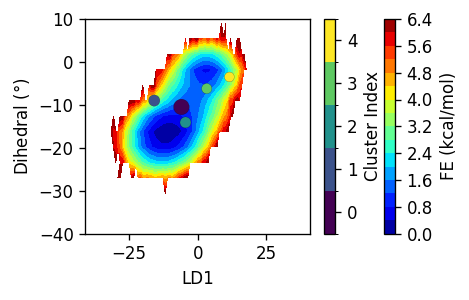

In [50]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

kt=0.616033 # in kcal/mol unit
hist, xedges, yedges = np.histogram2d(lda_projections, dihedral_synthetic, bins=[100,100], range=[[-41.0,41.0],[-180.0,180.0]], density=True)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe = -kt*np.log(hist)
fe -= fe.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4,2.6), dpi=120)
plt.xlim(-41.0,41.0)
plt.ylim(-40.0,10.0)
plt.xlabel("LD1")
plt.ylabel("Dihedral ($\\degree$)")
im1 = plt.contourf(xx, yy, fe.T, cmap="jet", levels=20)
cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(ld1_centers, dihedral_centers, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*250.0, edgecolor="k", linewidth=0.1)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

plt.tight_layout()

(153564,)
(1050001,)
(1050000,)


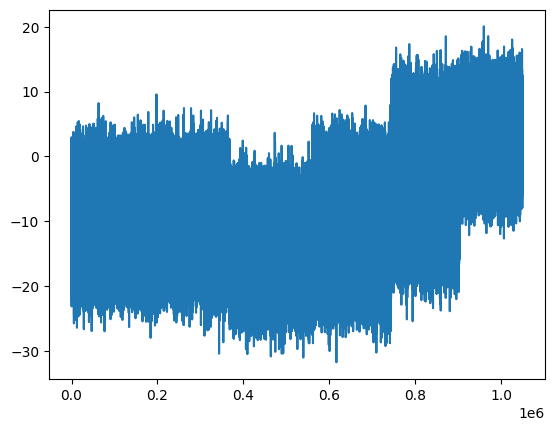

In [54]:
plt.plot(lda_projections)
print(ld1_rst.shape)
print(ld1.shape)
print(lda_projections.shape)

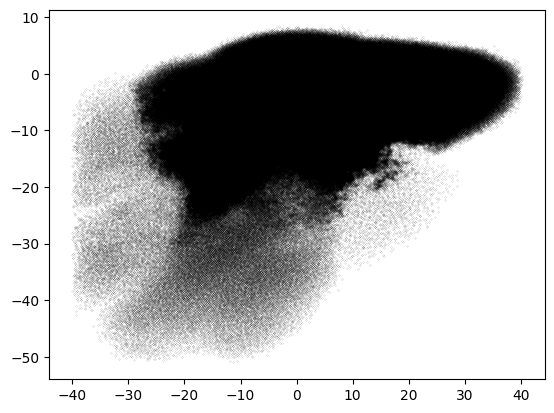

In [60]:
plt.scatter(ld1, dihedral*180/3.14, marker=".", s=0.02, color="b")